# Random windowing example use
This notebook illustrates the effect of the random windowing transformation on a CT image. 

## Download a CT volume from Ircad
The Ircad dataset contains 20 contrast-enhanced CT scans with segmentation masks. We download the first scan and convert it from DICOM to nifty format for easy handlig.

Each case is contained in a zipped folder available for download at
[ircad.fr](https://www.ircad.fr/research/data-sets/liver-segmentation-3d-ircadb-01/).

The following cell downloads and unpacks the first case from the ircad dataset.

In [76]:
import os
import zipfile
import requests
from tqdm import tqdm

# === CONFIG ===
download_url = "https://cloud.ircad.fr/index.php/s/JN3z7EynBiwYyjy/download?path=%2F3Dircadb1.1"
base_dir = "ircad_dataset"
zip_filename = "3Dircadb1.1.zip"
nifti_output_dir = os.path.join(base_dir, "nifti")
os.makedirs(base_dir, exist_ok=True)
os.makedirs(nifti_output_dir, exist_ok=True)

# === DOWNLOAD ===
zip_path = os.path.join(base_dir, zip_filename)
print("Downloading dataset...")
with requests.get(download_url, stream=True) as r:
    r.raise_for_status()
    total_size = int(r.headers.get('content-length', 0))
    with open(zip_path, 'wb') as f, tqdm(total=total_size, unit='iB', unit_scale=True) as bar:
        for chunk in r.iter_content(chunk_size=1024):
            f.write(chunk)
            bar.update(len(chunk))

# === UNZIP MAIN FILE ===
print("Extracting main zip...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(base_dir)
os.remove(zip_path)  # Remove the zip file after extraction


40.7MiB [00:48, 846kiB/s] 


Extracting main zip...


## Unpack and convert the ircad data to nifti
For easy handling of the 3D CT scan, the DICOM file is converted to nifti format. 

In [77]:
import shutil
import tempfile
import dicom2nifti

# === FUNCTION: Convert DICOM to NIfTI ===
def convert_single_dir_and_copy(dicom_dir, out_dir, data_id):
    with tempfile.TemporaryDirectory() as temp_dir:
        dicom2nifti.convert_directory(dicom_dir, temp_dir, reorient=True)
        for f in os.listdir(temp_dir):
            if f.endswith(".nii.gz"):
                src = os.path.join(temp_dir, f)

                dst = os.path.join(out_dir, f"{data_id.replace('.', '_')}.nii.gz")
                shutil.copy(src, dst)
                print(f"Converted and copied: {dst}")

# === FUNCTION: Unpack Nested Zips and Convert ===
def unpack_and_convert(patient_path, file_name):
    zip_file = os.path.join(patient_path, f"{file_name}.zip")
    if not os.path.isfile(zip_file):
        print(f"File not found: {zip_file}")
        return

    with tempfile.TemporaryDirectory() as temp_dir:
        print(f"Extracting {file_name}.zip...")
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(temp_dir)

        for root, dirs, _ in os.walk(temp_dir):
            for d in dirs:
                dir_path = os.path.join(root, d)
                if "image_0" in os.listdir(dir_path):
                    convert_single_dir_and_copy(dir_path, nifti_output_dir, os.path.basename(patient_path) + "_" + file_name)

# === PROCESS PATIENT FOLDER(S) ===
print("Processing extracted patient data...")
for item in os.listdir(base_dir):
    if item.startswith("3Dircadb"):
        patient_dir = os.path.join(base_dir, item)
        unpack_and_convert(patient_dir, "PATIENT_DICOM")



Processing extracted patient data...
Extracting PATIENT_DICOM.zip...
Converted and copied: ircad_dataset/nifti/3Dircadb1_1_PATIENT_DICOM.nii.gz


## Plot raw CT image
To visualize the CT image, the following code plots a slice of the volume without any intensity preprocessing. 

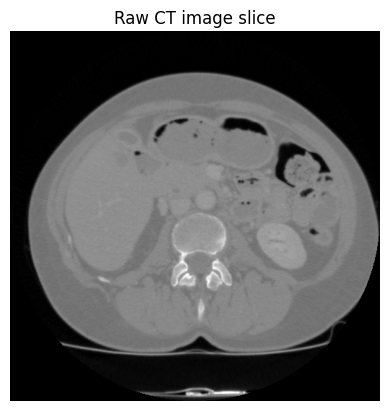

In [79]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

def reorient_vol(vol, ornt="RAS"):
    # Reorient volume to the specified orientation
    start_ornt = nib.orientations.io_orientation(vol.affine)
    end_ornt = nib.orientations.axcodes2ornt(ornt)
    transform = nib.orientations.ornt_transform(start_ornt, end_ornt)

    vol = vol.as_reoriented(transform)
    return vol

img_path = "ircad_dataset/nifti/3Dircadb1_1_PATIENT_DICOM.nii.gz"

# Load the NIfTI images
img = nib.load(img_path)
img = reorient_vol(img, "PLS")
img_vol = img.get_fdata()

plt.figure()
plt.imshow(img_vol[:, :, 50], cmap="gray")
plt.title("Raw CT image slice")
plt.axis("off")
plt.show()

## Preprocessing
The standard practice when analyzing CT images is to apply a "viewing window" to the intensities. The intensities in a CT image are hounsfield units (HU) and different anatomical regions have different characteristic values.

The viewing window increase the constrast for the region you are looking at, by clipping the intensities to a narrower range suitable for the region of interest.

The base viewing window operation use a "window level" as the center of the viewing window intensities, and a "window width" for the size of range of intensities.  

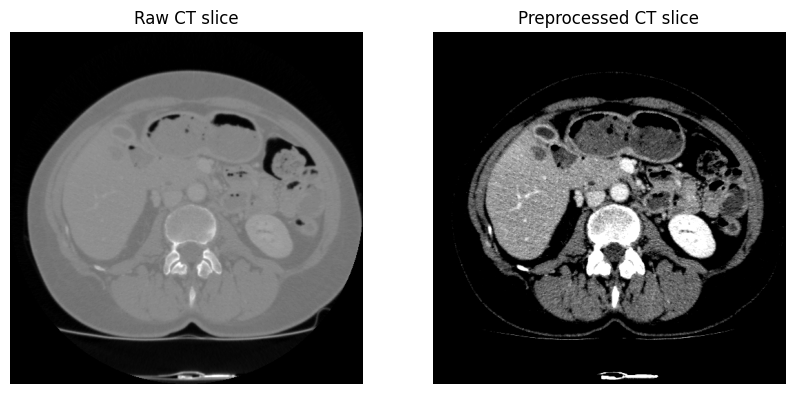

In [80]:
from transforms import RandomWindower

window = [250, 90]  # window width, window level

# Use the RandomWindower class to apply the windowing by setting p_shift and p_scale to 0
windower = RandomWindower(p_shift=0, p_scale=0, base_window=window)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img_vol[:, :, 50], cmap="gray")
axs[0].set_title("Raw CT slice")
axs[0].axis("off")

axs[1].imshow(windower(img_vol[:, :, 50]), cmap="gray")
axs[1].set_title("Preprocessed CT slice")
axs[1].axis("off")

plt.show()

## Random windowing
Random windowing randomly shifts and scales the viewing window by sampling new window levels and window widths relevant for the region.

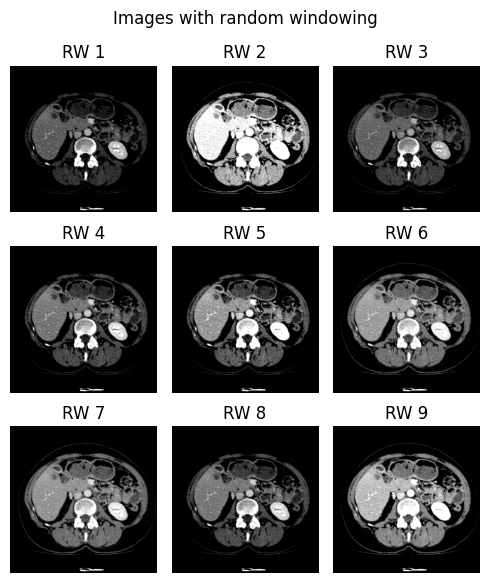

In [85]:
# Random windowing parameters
range_level = [11.5, 152.9]
range_scale = [141.2, 325.9]

random_windower = RandomWindower(
    p_shift=1.0, 
    p_scale=1.0, 
    base_window=window,
    range_level=range_level,
    range_scale=range_scale)


# n x n grid of random windowed images
n_rows = 3
n_cols = 3 
fig, axs = plt.subplots(n_rows, n_cols, figsize=(5, 6))
for i in range(n_rows):
    for j in range(n_cols):
        axs[i, j].imshow(random_windower(img_vol[:, :, 50]), cmap="gray")
        axs[i, j].axis("off")
        axs[i, j].set_title(f"RW {i*n_cols+j+1}")

plt.suptitle("Images with random windowing")
plt.tight_layout()
plt.show()